In [1]:
import numpy as np                  # Scientific Computing Library
import matplotlib.pyplot as plt     # Basic Visualization Library
from h5dataset import H5DatasetLoader
from config_v1 import read_radar_params
from v1 import RadarFrame
from mmwave import dsp
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = H5DatasetLoader(r"E:\OneDrive - UNSW\PhD\Experiments\2021-06\openradar\data\indoor_sample_50.h5")

In [3]:
# Read config and configure RadarFrame object
radar_config = read_radar_params(r'indoor_human_rcs.cfg')
rf = RadarFrame(radar_config)
range_resolution = rf.range_resolution
range_resolution

0.04683764076549342

In [12]:
numRangeBins = rf.range_nbins
numRangeBins

304

In [4]:
max_range = rf.max_range

In [5]:
class Window:
    BARTLETT = 1
    BLACKMAN = 2
    HAMMING  = 3
    HANNING  = 4


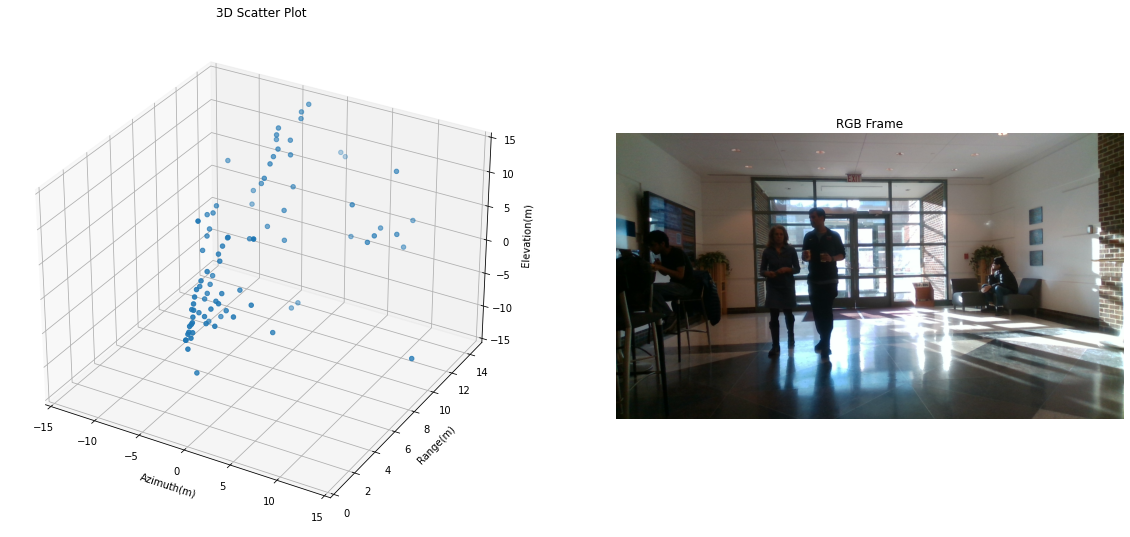

In [18]:
for i in range(data['radar'].shape[0]):
    radar_cube = np.swapaxes(data['radar'][i], 0, 2)
    range_cube = dsp.range_processing(radar_cube)
    det_matrix, aoa_input = dsp.doppler_processing(radar_cube)
    

    fft2d_sum = det_matrix.astype(np.int64)
    thresholdDoppler, noiseFloorDoppler = np.apply_along_axis(func1d=dsp.ca_,
                                                                axis=0,
                                                                arr=fft2d_sum.T,
                                                                l_bound=1.5,
                                                                guard_len=4,
                                                                noise_len=16)

    thresholdRange, noiseFloorRange = np.apply_along_axis(func1d=dsp.ca_,
                                                            axis=0,
                                                            arr=fft2d_sum,
                                                            l_bound=2.5,
                                                            guard_len=4,
                                                            noise_len=16)

    thresholdDoppler, noiseFloorDoppler = thresholdDoppler.T, noiseFloorDoppler.T
    det_doppler_mask = (det_matrix > thresholdDoppler)
    det_range_mask = (det_matrix > thresholdRange)

    # # Get indices of detected peaks
    full_mask = (det_doppler_mask & det_range_mask)
    det_peaks_indices = np.argwhere(full_mask == True)

    # # peakVals and SNR calculation
    peakVals = fft2d_sum[det_peaks_indices[:, 0], det_peaks_indices[:, 1]]
    snr = peakVals - noiseFloorRange[det_peaks_indices[:, 0], det_peaks_indices[:, 1]]
    numTxAntennas = 2
    dtype_location = '(' + str(numTxAntennas) + ',)<f4'
    dtype_detObj2D = np.dtype({'names': ['rangeIdx', 'dopplerIdx', 'peakVal', 'location', 'SNR'],
                                'formats': ['<i4', '<i4', '<f4', dtype_location, '<f4']})
    detObj2DRaw = np.zeros((det_peaks_indices.shape[0],), dtype=dtype_detObj2D)
    detObj2DRaw['rangeIdx'] = det_peaks_indices[:, 0].squeeze()
    detObj2DRaw['dopplerIdx'] = det_peaks_indices[:, 1].squeeze()
    detObj2DRaw['peakVal'] = peakVals.flatten()
    detObj2DRaw['SNR'] = snr.flatten()
    numDopplerBins = 304
    # # Further peak pruning. This increases the point cloud density but helps avoid having too many detections around one object.
    detObj2DRaw = dsp.prune_to_peaks(detObj2DRaw, det_matrix, numDopplerBins, reserve_neighbor=True)

    # # --- Peak Grouping
    # detObj2D = dsp.peak_grouping_along_doppler(detObj2DRaw, det_matrix, numDopplerBins)
    # SNRThresholds2 = np.array([[2, 23], [10, 11.5], [35, 16.0]])
    # peakValThresholds2 = np.array([[4, 275], [1, 400], [500, 0]])
    # detObj2D = dsp.range_based_pruning(detObj2D, SNRThresholds2, peakValThresholds2, numRangeBins, 0.5, range_resolution)
    
    azimuthInput = aoa_input[detObj2DRaw['rangeIdx'], :, detObj2DRaw['dopplerIdx']]
    x, y, z = dsp.naive_xyz(azimuthInput.T,num_rx=4,num_tx=3)

    xyzVecN = np.zeros((3, x.shape[0]))
    xyzVecN[0] = x * range_resolution *max_range*detObj2DRaw['rangeIdx']
    xyzVecN[1] = y * range_resolution *max_range*detObj2DRaw['rangeIdx']
    xyzVecN[2] = z * range_resolution *max_range*detObj2DRaw['rangeIdx']

    fig = plt.figure(figsize=(20,20))

    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    ax1.set_title("3D Scatter Plot")
    ax1.scatter(xyzVecN[0], xyzVecN[1], xyzVecN[2])
    ax1.set_xlabel('Azimuth(m)')
    ax1.set_ylabel('Range(m)')
    ax1.set_zlabel('Elevation(m)')
    ax1.set_xlim3d(-15, 15)
    ax1.set_ylim3d(0, 15)
    ax1.set_zlim3d(-15,15 )

    ax2.set_title("RGB Frame")
    ax2.imshow(data['rgb'][i][:, :, ::-1])
    ax2.set_axis_off()
    
    plt.subplots_adjust(wspace=0.2)
    plt.savefig('3d_scatter_'+str(i)+'_.png', bbox_inches = "tight",dpi=150)
    break;    
